In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [2]:
# Mersenne Twister com NumPy
# Define a semente para reprodutibilidade
np.random.seed(42)  
# ----------------------------- Parâmetros do Sistema -------------------------
# Número de usuários móveis (MSs) no sistema MIMO massivo.
Num_users = 4
# Número de Antenas na Estação Base (TX)
# A estação base (BS) usa uma matriz de antenas plana uniforme (UPA) com 64 antenas.
TX_ant = 64
# Número de Antenas no Receptor (RX)
# Cada usuário (MS) tem uma UPA menor de 4 antenas.
RX_ant = 4
# Parâmetros do Canal
Num_paths = 10  # Número de caminhos no canal
# ----------------------------- Parâmetros da Simulação ---------------------
# Cria uma faixa de valores de SNR (Signal-to-Noise Ratio) em decibéis (dB).
SNR_dB_range = np.arange(-10, 25, 5)  # Gera valores de SNR de -10 dB a 20 dB, com incremento de 5 dB

In [3]:
# ----------------------------- Matrizes para Armazenar as Taxas de Transmissão ---------------------
# Taxa para um único usuário (Single User - SU)
Rate_SU = np.zeros(len(SNR_dB_range)) 
# Taxa na estação base (Base Station - BS)
Rate_BS = np.zeros(len(SNR_dB_range)) 
# Taxa usando precoding híbrido (Hybrid Precoding - HP)
Rate_HP = np.zeros(len(SNR_dB_range))  
# Taxa usando Precoding híbrido baseado no critério de erro médio quadrático (MSE)
Rate_HP_MSE = np.zeros(len(SNR_dB_range)) 
# Taxa usando Precoding híbrido usando Filtro de Kalman
Rate_HP_Kalman = np.zeros(len(SNR_dB_range))
# Taxa usando Precoding Totalmente Digital com Zero Forcing (ZF)
Rate_HP_FD_ZF = np.zeros(len(SNR_dB_range))
# Taxa usando 	Precoding Totalmente Digital com MSE
Rate_HP_FD_MSE = np.zeros(len(SNR_dB_range))

# ----------------------------- Número de Iterações ---------------------
# Define 500 iterações para cada valor de SNR, 
# Permite obter médias estatísticas confiáveis, reduzindo a variabilidade dos resultados.
ITER = 500

In [4]:
def generate_massive_mimo_channel(Num_users, Num_paths, TX_ant, RX_ant):
    
    # TX_ant_w e TX_ant_h calculam a largura e altura da matriz assumindo um arranjo quadrado
    TX_ant_w = int(np.sqrt(TX_ant))  # Largura
    TX_ant_h = int(np.sqrt(TX_ant))  # Altura

    # RX_ant_w e RX_ant_h calculam a largura e altura da matriz assumindo um arranjo quadrado
    RX_ant_w = int(np.sqrt(RX_ant)) # Largura
    RX_ant_h = int(np.sqrt(RX_ant)) # Altura

    # Cria índices das antenas na matriz UPA para ajudar no mapeamento espacial.
    # Índices das antenas no grid da UPA
    ind_TX_w = np.repeat(np.arange(TX_ant_w), TX_ant_h)
    ind_TX_h = np.tile(np.arange(TX_ant_h), TX_ant_w)

    # Índices das antenas da matriz UPA do receptor, de forma similar ao transmissor.
    ind_RX_w = np.repeat(np.arange(RX_ant_w), RX_ant_h)
    ind_RX_h = np.tile(np.arange(RX_ant_h), RX_ant_w)
    
    # Inicialização das Matrizes
    H = np.zeros((Num_users, RX_ant_w * RX_ant_h, TX_ant_w * TX_ant_h), dtype=complex)
    a_TX = np.zeros((TX_ant_w * TX_ant_h, Num_users), dtype=complex)
    a_RX = np.zeros((RX_ant_w * RX_ant_h, Num_users), dtype=complex)

    AoD_el = np.zeros((Num_users, Num_paths))
    AoD_az = np.zeros((Num_users, Num_paths))
    AoA_el = np.zeros((Num_users, Num_paths))
    AoA_az = np.zeros((Num_users, Num_paths))
    alpha = np.zeros((Num_users, Num_paths), dtype=complex)

    for u in range(Num_users):
        AoD_el[u, :] = np.pi * np.random.rand(Num_paths) - np.pi / 2
        AoD_az[u, :] = 2 * np.pi * np.random.rand(Num_paths)
        AoA_el[u, :] = np.pi * np.random.rand(Num_paths) - np.pi / 2
        AoA_az[u, :] = 2 * np.pi * np.random.rand(Num_paths)

        alpha[u, :] = np.sqrt(1 / Num_paths) * (norm.ppf(np.random.rand(Num_paths)) +
                                                1j * norm.ppf(np.random.rand(Num_paths)))

        Temp_Channel = np.zeros((RX_ant_w * RX_ant_h, TX_ant_w * TX_ant_h), dtype=complex)

        for l in range(Num_paths):
            norm_vec_tx = np.sqrt(1 / (TX_ant_w * TX_ant_h))
            az_el_angle_tx = ind_TX_w * np.sin(AoD_az[u, l]) * np.sin(AoD_el[u, l])
            vertical_part_tx = ind_TX_h * np.cos(AoD_el[u, l])
            phase_response_tx = np.exp(1j * np.pi * (az_el_angle_tx + vertical_part_tx))
            a_TX[:, u] = (norm_vec_tx * phase_response_tx).flatten(order='F')

            norm_vec_rx = np.sqrt(1 / (RX_ant_w * RX_ant_h))
            az_el_angle_rx = ind_RX_w * np.sin(AoA_az[u, l]) * np.sin(AoA_el[u, l])
            vertical_part_rx = ind_RX_h * np.cos(AoA_el[u, l])
            phase_response_rx = np.exp(1j * np.pi * (az_el_angle_rx + vertical_part_rx))
            a_RX[:, u] = (norm_vec_rx * phase_response_rx).flatten(order='F')

            norm_ant = np.sqrt((TX_ant_w * TX_ant_h) * (RX_ant_w * RX_ant_h))
            Temp_Channel += (norm_ant) * np.outer(alpha[u, l] * a_RX[:, u], a_TX[:, u].conj())

        H[u, :, :] = Temp_Channel  # Atualiza a matriz do canal para o usuário u

    return H, a_TX, a_RX

In [5]:
def hybrid_precoding(H, a_TX, a_RX, Num_users, TX_ant, RX_ant):
    """
    Realiza a precificação híbrida e constrói os canais efetivos.

    Parâmetros:
    H        : ndarray (Num_users, RX_ant, TX_ant) - Matriz do canal MIMO massivo
    a_TX     : ndarray (TX_ant, Num_users) - Vetores de resposta ao array no transmissor
    a_RX     : ndarray (RX_ant, Num_users) - Vetores de resposta ao array no receptor
    Num_users: int - Número de usuários
    RX_ant   : int - Número de antenas no receptor
    TX_ant   : int - Número de antenas no transmissor

    Retorna:
    He    : ndarray (Num_users, RX_ant) - Canal efetivo híbrido considerando precificação analógica.
    He_fd : ndarray (Num_users, TX_ant) - Canal efetivo para precificação digital completa.
    Frf   : ndarray (TX_ant, Num_users) - Matriz de precodificação híbrida no transmissor.
    Wrf   : ndarray (RX_ant, Num_users) - Matriz de precodificação híbrida no receptor.
    """
    # Inicialização das matrizes de precodificação híbrida
    Frf = np.zeros((TX_ant, Num_users), dtype=complex)
    Wrf = np.zeros((RX_ant, Num_users), dtype=complex)

    # Define os precodificadores híbridos
    for u in range(Num_users):
        Frf[:, u] = a_TX[:, u]
        Wrf[:, u] = a_RX[:, u]

    # Construção dos Canais Efetivos
    He = np.zeros((Num_users, RX_ant), dtype=complex)
    for u in range(Num_users):
        Channel = H[u, :, :]  # Extraindo a matriz H do usuário u
        He[u, :] = Wrf[:, u].conj().T @ Channel @ Frf  # Cálculo do canal efetivo híbrido

    # Construção dos Canais Efetivos para Precificação Digital Completa
    He_fd = np.zeros((Num_users, TX_ant), dtype=complex)
    for u in range(Num_users):
        Channel = H[u, :, :]  # Extraindo a matriz H do usuário u
        He_fd[u, :] = Wrf[:, u].conj().T @ Channel  # Cálculo do canal efetivo totalmente digital

    return He, He_fd, Frf, Wrf

In [6]:
def zero_forcing_precoding(He, He_fd, Frf, Num_users):
    """
    Realiza a precificação Zero-Forcing (ZFBF) para os cenários híbrido e totalmente digital.

    Parâmetros:
    He       : ndarray (Num_users, RX_ant) - Canal efetivo híbrido.
    He_fd    : ndarray (Num_users, TX_ant) - Canal efetivo totalmente digital.
    Frf      : ndarray (TX_ant, Num_users) - Matriz de precodificação híbrida no transmissor.
    Num_users: int - Número de usuários.

    Retorna:
    Fbb : ndarray (Num_users, Num_users) - Matriz de precodificação baseband híbrida.
    Ffd : ndarray (TX_ant, Num_users) - Matriz de precodificação baseband totalmente digital.
    """

    # Baseband Zero-Forcing Precoding (ZFBF) para precificação híbrida
    Fbb = He.conj().T @ np.linalg.inv(He @ He.conj().T)

    # Normalização dos precodificadores híbridos
    for u in range(Num_users):
        norm_factor = np.sqrt((Frf @ Fbb[:, u]).conj().T @ (Frf @ Fbb[:, u]))
        if norm_factor != 0:  # Evitar divisão por zero
            Fbb[:, u] /= norm_factor  # Normalização

    # Fully-Digital Zero-Forcing Precoding (ZFBF)
    Ffd = He_fd.conj().T @ np.linalg.pinv(He_fd @ He_fd.conj().T)

    # Normalização dos precodificadores totalmente digitais
    for u in range(Num_users):
        norm_factor = np.linalg.norm(Ffd[:, u])  # Correta normalização da coluna
        if norm_factor != 0:  # Evitar divisão por zero
            Ffd[:, u] /= norm_factor

    return Fbb, Ffd

In [7]:
def mmse_baseband_precoder(He, Frf, Num_users, SNR_dB):
    """
    Calcula o precodificador MMSE na baseband para precificação híbrida.

    Parâmetros:
    He       : ndarray (Num_users, RX_ant) - Canal efetivo híbrido.
    Frf      : ndarray (TX_ant, Num_users) - Matriz de precodificação híbrida no transmissor.
    Num_users: int - Número de usuários.
    SNR_dB   : float - Relação sinal-ruído (SNR) em dB.

    Retorna:
    FbbMSE : ndarray (Num_users, Num_users) - Matriz de precodificação MMSE na baseband.
    """

    SNR = 10 ** (0.1 * SNR_dB) / Num_users  # Converter dB para valor linear
    sigma2 = 1 / SNR  # Variância do ruído

    # Cálculo do precodificador MMSE na baseband
    FbbMSE = np.linalg.inv(He.conj().T @ He + Num_users * sigma2 * Frf.conj().T @ Frf) @ He.conj().T

    # Normalização dos precodificadores híbridos
    for u in range(Num_users):
        norm_factor = np.linalg.norm(Frf @ FbbMSE[:, u])
        if norm_factor != 0:  # Evitar divisão por zero
            FbbMSE[:, u] /= norm_factor

    return FbbMSE


In [8]:
def mmse_fully_digital_precoding(He_fd, TX_ant, Num_users, SNR_dB):
    """
    Calcula o precodificador MMSE para precificação totalmente digital.

    Parâmetros:
    He_fd    : ndarray (Num_users, TX_ant) - Canal efetivo totalmente digital.
    TX_ant   : int - Número de antenas no transmissor.
    Num_users: int - Número de usuários.
    SNR_dB   : float - Relação sinal-ruído (SNR) em dB.

    Retorna:
    FfdMSE : ndarray (TX_ant, Num_users) - Matriz de precodificação MMSE totalmente digital.
    """

    SNR = 10 ** (0.1 * SNR_dB) / Num_users  # Converter dB para valor linear
    sigma2 = 1 / SNR  # Variância do ruído

    # Cálculo do precodificador MMSE totalmente digital
    FfdMSE = np.linalg.inv(He_fd.conj().T @ He_fd + Num_users * sigma2 * np.eye(TX_ant)) @ He_fd.conj().T

    # Normalização dos precodificadores totalmente digitais
    for u in range(Num_users):
        norm_factor = np.linalg.norm(FfdMSE[:, u])  # Correta normalização da coluna
        if norm_factor != 0:  # Evitar divisão por zero
            FfdMSE[:, u] /= norm_factor

    return FfdMSE


In [9]:
def single_user_rate(H, TX_ant, RX_ant,Num_users,SNR_dB):
    """
    Calcula a taxa de dados para o caso Single-User (SU).

    Parâmetros:
    H        : ndarray (Num_users, RX_ant, TX_ant) - Matriz do canal MIMO massivo.
    SNR_dB   : float - Relação sinal-ruído (SNR) em dB.
    Num_users: int - Número de usuários.
    RX_ant   : int - Número de antenas no receptor.
    TX_ant   : int - Número de antenas no transmissor.

    Retorna:
    Rate_SU : float - Taxa média de dados no caso de um único usuário.
    """

    SNR = 10 ** (0.1 * SNR_dB) / Num_users  # Converter dB para valor linear
    Rate_SU = 0

    for u in range(Num_users):
        # Extraindo a matriz de canal do usuário u
        Channel = H[u, :, :]

        # Decomposição SVD
        U_channel, S_diag, V_channel = np.linalg.svd(Channel)

        # Expandir S_channel para uma matriz do mesmo tamanho
        S_channel = np.zeros((U_channel.shape[0], V_channel.shape[0]))
        np.fill_diagonal(S_channel, S_diag)  # Preenche a diagonal com os valores singulares

        # Taxa Single-User
        Rate_SU += np.log2(1 + SNR * S_channel[0, 0] ** 2) / Num_users

    return Rate_SU


In [10]:
def analog_only_beamforming_rate(H, TX_ant, RX_ant, Wrf, Frf, Num_users,SNR_dB):
    """
    Calcula a taxa de dados para beamforming apenas analógico.

    Parâmetros:
    H        : ndarray (Num_users, RX_ant, TX_ant) - Matriz do canal MIMO massivo.
    Wrf      : ndarray (RX_ant, Num_users) - Matriz de precodificação híbrida no receptor.
    Frf      : ndarray (TX_ant, Num_users) - Matriz de precodificação híbrida no transmissor.
    SNR_dB   : float - Relação sinal-ruído (SNR) em dB.
    Num_users: int - Número de usuários.
    RX_ant   : int - Número de antenas no receptor.
    TX_ant   : int - Número de antenas no transmissor.

    Retorna:
    Rate_BS : float - Taxa média de dados no beamforming analógico.
    """

    SNR = 10 ** (0.1 * SNR_dB) / Num_users  # Converter dB para valor linear
    Rate_BS = 0

    for u in range(Num_users):
        Int_set = [i for i in range(Num_users) if i != u]  # Índices de interferência

        # Extraindo a matriz de canal do usuário u
        Channel = H[u, :, :]

        # Cálculo do SINR para beamforming analógico
        numerador = SNR * (np.abs(Wrf[:, u].conj().T @ Channel @ Frf[:, u]) ** 2)
        denominador = SNR * np.sum(np.abs(Wrf[:, u].conj().T @ Channel @ Frf[:, Int_set]) ** 2) + 1
        SINR_BS = numerador / denominador

        # Atualiza a taxa do beamforming analógico
        Rate_BS += np.log2(1 + SINR_BS) / Num_users

    return Rate_BS


In [ ]:
def calculate_rate(H_eff, Precoder, Num_users, SNR, ITER):
    """
    Calcula a taxa de transmissão de um sistema MIMO com precificação digital.

    Parâmetros:
    H_eff    : ndarray (Num_users, TX_ant) - Canal efetivo digital 
    Precoder : ndarray (TX_ant, Num_users) - Matriz de precodificação
    Num_users: int - Número de usuários
    SNR      : float - Relação sinal-ruído (convertida para escala linear)
    ITER     : int - Número de iterações para normalização da taxa

    Retorna:
    Rate : float - Taxa de transmissão média por usuário
    """
    # Matriz identidade para referência
    Mat_eye = np.eye(Num_users)

    # Covariância do precoder (distribuição de potência)
    Mat_precoder = Precoder @ Precoder.conj().T  

    # Aplicação do canal efetivo
    Mat_H_eff = H_eff @ Mat_precoder @ H_eff.conj().T  

    # Multiplicação pelo SNR
    Mat_SNR = SNR * Mat_H_eff  

    # Matriz final incluindo interferência e ruído
    Mat_res = Mat_eye + Mat_SNR  

    # Determinante da matriz resultante
    det_mat = np.linalg.det(Mat_res)

    # Evita erro caso o determinante seja zero ou negativo
    if det_mat <= 0:
        return 0.0  

    # Cálculo da taxa de transmissão (bits/s/Hz por usuário)
    Rate = np.real(np.log2(det_mat) / (Num_users * ITER))

    return Rate

In [12]:
# Simulação
for iter in range(ITER):
    [H, a_TX, a_RX] = generate_massive_mimo_channel(Num_users, Num_paths, TX_ant, RX_ant)
    ################################################################################################
    [He, He_fd, Frf, Wrf] = hybrid_precoding(H, a_TX, a_RX, Num_users, TX_ant, RX_ant)
    ################################################################################################
    [Fbb, Ffd] = zero_forcing_precoding(He, He_fd, Frf, Num_users)
    ################################################################################################
    count_i = 0
    for count, SNR_dB_i in enumerate(SNR_dB_range, start=1):
        count_i = count_i + 1
        SNR = 10 ** (0.1 * SNR_dB_i) / Num_users  # Converter dB para valor linear
        sigma2 = 1 / SNR  # Variância do ruído
        ################################################################################################
        Rate_SU[count_i - 1] = single_user_rate(H, TX_ant, RX_ant, Num_users,SNR_dB_i)
        Rate_BS[count_i - 1] = analog_only_beamforming_rate(H, TX_ant, RX_ant, Wrf, Frf, Num_users,SNR_dB_i)
        ################################################################################################
        # MMSE Baseband Precoder
        FbbMSE = mmse_baseband_precoder(He, Frf, Num_users, SNR_dB_i)
        # Fully-Digital MMSE Precoding
        FfdMSE = mmse_fully_digital_precoding(He_fd, TX_ant, Num_users, SNR_dB_i)
        # MSE fully digital precoding
        Rate_HP_FD_MSE[count_i - 1] += calculate_rate(He_fd, FfdMSE, Num_users, SNR, ITER)
        # Hybrid Precoding
        Rate_HP[count_i - 1] += calculate_rate(He, Fbb, Num_users, SNR, ITER)
        # Hybrid Precoding MMSE
        Rate_HP_MSE[count_i - 1] += calculate_rate(He, FbbMSE, Num_users, SNR, ITER)



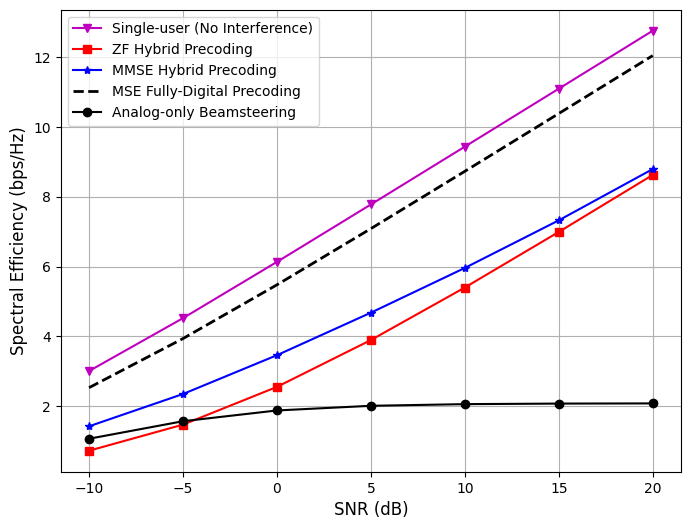

In [13]:
# Plotando a eficiência espectral
plt.figure(figsize=(8, 6))
# plt.plot(SNR_dB_range, Rate_HP_FD_ZF, '-gv', linewidth=1.5, label="ZF fully digital precoding")
plt.plot(SNR_dB_range, Rate_SU, '-mv', linewidth=1.5, label="Single-user (No Interference)")
plt.plot(SNR_dB_range, Rate_HP, '-rs', linewidth=1.5, label="ZF Hybrid Precoding")
plt.plot(SNR_dB_range, Rate_HP_MSE, '-b*', linewidth=1.5, label="MMSE Hybrid Precoding")
plt.plot(SNR_dB_range, Rate_HP_FD_MSE, '--k', linewidth=2, label="MSE Fully-Digital Precoding")
# Verificando a condição para o número de caminhos
if Num_paths == 1:
    plt.plot(SNR_dB_range, Rate_BS, '-ro', linewidth=1.5, label="Analog-only Beamsteering")
else:
    plt.plot(SNR_dB_range, Rate_BS, '-ko', linewidth=1.5, label="Analog-only Beamsteering")
# Configurações do gráfico
plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('Spectral Efficiency (bps/Hz)', fontsize=12)
plt.legend()
plt.grid()
plt.show()